In [438]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

In [140]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning - exploring predictions of mean telomere length post-therapy

## Loading/merging data for ML

In [420]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [421]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                             all_patients_df=all_patients_df)

telo_data.head()

,patient id,timepoint,individual telomeres,4 C telo means
0,1,1 non irrad,92.916201,99.346299
1,1,2 irrad @ 4 Gy,112.977654,99.346299
2,1,1 non irrad,65.463687,99.346299
3,1,2 irrad @ 4 Gy,104.530726,99.346299
4,1,1 non irrad,61.240223,99.346299


## Train/test split 

In [475]:
telo_test = telo_data.copy()
# telo_test = telo_test[~telo_test['patient id'].isin([2, 6, 11])]
train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id',
                                                                                                   'timepoint']])

In [422]:
# telo_test = telo_data.copy()

# y = telo_test[['4 C telo means']]
# X = telo_test.drop(['4 C telo means'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=X[['patient id', 
#                                                                                                    'timepoint']])

# train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
# test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [456]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [457]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=0)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning/modeling data with pipeline

In [476]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

## Random GridSearch for pipeline/model params

In [ ]:
# #XGBoost params for random grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Bayesian Optimization

In [442]:
# target = '4 C telo means'
# features = [col for col in train_clean if col != target and col != 'patient id']

# X_train = train_clean[features].copy()
# y_train = train_clean[target].copy()

In [451]:
# pbounds = {
#     'learning_rate': (0.1, 0.2),
#     'n_estimators': (100, 200),
#     'max_depth': (3, 30),
#     'subsample': (.80, 1.0),  
#     'colsample': (1.0, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 1)}

# def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
#                         subsample, colsample, gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = XGBRegressor(max_depth=max_depth,
#                        learning_rate=learning_rate,
#                        n_estimators=n_estimators,
#                        gamma=gamma, objective='reg:squarederror')
    
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=10, n_iter=5)

In [472]:
# bayesian optimized model
bo_model = XGBRegressor(n_estimators=260, max_depth=17, learning_rate=0.25,
                       objective ='reg:squarederror', random_state=0, subsample=.9,
                       gamma=1.7)

## Cross validation; MAE & R2 score - predicting mean telo telo post-therapy (4 C) using individual telos

In [473]:
fit_xgb_model = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                          model=model, cv=5)

MAE per CV fold: 
[0.24681493 0.28069254 0.27735928 0.24357757 0.26625496] 

MEAN of MAE all folds: 0.2629398547236823
STD of MAE all folds: 0.015290380371862861

MAE of predict_y_test & y_test: 0.23205458578746527
R2 between predict_y_test & y_test: 0.9875505973324449


In [477]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_xgb_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe)

patient 1: ACTUAL 4 C telo means: 99.35 --- PREDICTED 4 C telo means: 99.25
patient 2: ACTUAL 4 C telo means: 108.92 --- PREDICTED 4 C telo means: 98.37
patient 3: ACTUAL 4 C telo means: 95.67 --- PREDICTED 4 C telo means: 95.65
patient 5: ACTUAL 4 C telo means: 97.83 --- PREDICTED 4 C telo means: 97.80
patient 6: ACTUAL 4 C telo means: 130.12 --- PREDICTED 4 C telo means: 97.49
patient 7: ACTUAL 4 C telo means: 101.40 --- PREDICTED 4 C telo means: 101.27
patient 8: ACTUAL 4 C telo means: 106.65 --- PREDICTED 4 C telo means: 106.41
patient 9: ACTUAL 4 C telo means: 107.67 --- PREDICTED 4 C telo means: 107.41
patient 10: ACTUAL 4 C telo means: 93.35 --- PREDICTED 4 C telo means: 93.47
patient 11: ACTUAL 4 C telo means: 108.57 --- PREDICTED 4 C telo means: 96.43
patient 12: ACTUAL 4 C telo means: 73.99 --- PREDICTED 4 C telo means: 74.29
patient 14: ACTUAL 4 C telo means: 93.28 --- PREDICTED 4 C telo means: 93.31
patient 15: ACTUAL 4 C telo means: 90.68 --- PREDICTED 4 C telo means: 90.8

Text(0.5, 1.0, 'Fig. 1')

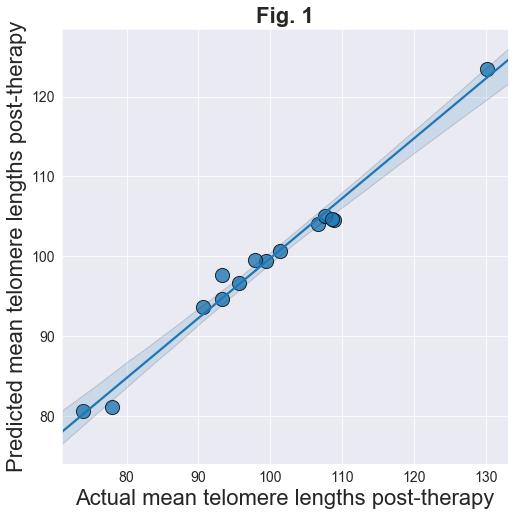

In [106]:
plt.figure(figsize=(8,8))
ax = sns.regplot(x=y_true_list, y=y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=22)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=22)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 1', fontsize=22, weight='bold')
# plt.savefig('predicting mean telos 3 months post.png')

In [ ]:
from xgboost import plot_tree

plot_tree(fit_xgb_model)

## Looking directly at actual test 4 C telo means vs. predicted test 4 C telo means

In [ ]:
test_clean_process_pipe = clean_process_pipe.set_params(cleaner__drop_patient_id=False)

test_run = test_set.copy()
test_run2 = test_clean_process_pipe.fit_transform(test_run)

In [ ]:
test_run2_pred = fit_xgb_model.predict(test_run2[['individual telomeres', 'timepoint_1']])
df_test_run2_pred = pd.DataFrame({'4C telo PREDICTIONS': test_run2_pred})

viz = pd.concat([test_run2, df_test_run2_pred], axis=1)
viz.corr()

In [ ]:
viz[viz['patient id'] == 5].groupby('patient id').agg('mean')

## Testing if model can predict 4C mean telomere length using *means

In [ ]:
all_patients_4C = trp.combine_data(exploded_telos=exploded_telos_all_patients_df,
                                   all_patients_df=all_patients_df,
                                   prediction_objective='4 C means from telo means')

In [ ]:
ML_mean_telos_pre = clean_process_pipe.set_params(cleaner__drop_patient_id=False).fit_transform(all_patients_4C)
ML_mean_telos_clean = ML_mean_telos_pre.copy()

# renaming telos means to enable compatability w/ model
ML_mean_telos_clean.rename(columns={'telo means':'individual telomeres'}, inplace=True)
# dropping to ensure only timepoint/ "individual telomeres" are seen by model
ML_mean_telos_clean.drop(['patient id', '4 C telo means'], axis=1, inplace=True)

In [ ]:
pred_4C_telos = model.predict(ML_mean_telos_clean)
pred_4C_telos = pd.DataFrame({'y PREDICT 4C telos': pred_4C_telos})
alpha = pd.concat([ML_mean_telos_pre[['patient id', '4 C telo means']], pred_4C_telos], axis=1)[['patient id', '4 C telo means', 'y PREDICT 4C telos']]
alpha.corr()

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=alpha['4 C telo means'], y=alpha['y PREDICT 4C telos'])
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

## Testing if linear regression can predict 4C mean telos using individual telos

In [134]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

fit_lr_model = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean, 
                                         pipe=lr_pipe, model=lr_model, cv=5)

MAE per CV fold: 
[9.50646244 9.63597336 9.44524462 9.48229668 9.50325208] 

MEAN of MAE all folds: 9.514645837533445
STD of MAE all folds: 0.0644672770023963

MAE of predict_y_test & y_test: 9.511133811589918
R2 between predict_y_test & y_test: 0.04561072746690764


In [135]:
y_lr_predict, y_true = trp.predict_target_4C_compare_actual(telo_data=telo_data_qualify, 
                                                           train_set=train_clean, test_set=test_clean, model=lr_model)

NameError: name 'telo_data_qualify' is not defined

In [ ]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=y_true, y=y_lr_predict)
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

In [ ]:
sns.lineplot(x='timepoint', y='telo means', hue='patient id', data=all_patients_df[all_patients_df['patient id'].isin([12, 14, 15, 16])])

In [ ]:
sns.lineplot(x='timepoint', y='telo means', hue='patient id', data=all_patients_df[~all_patients_df['patient id'].isin([12, 13, 14, 15, 16])])

In [ ]:
training_MAE = []
test_MAE = []
max_depth_XGB = [3, 4, 5, 10, 15, 20, 25]

X = train_clean[['timepoint_1', 'individual telomeres']]
y = train_clean['4 C telo means']

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=0)

X_test = test_clean[['timepoint_1', 'individual telomeres']]
y_test = test_clean['4 C telo means']

for param in max_depth_XGB:
    model = XGBRegressor(max_depth=param, learning_rate=0.1, n_estimators=100, objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    predict_y_val = model.predict(X_val)
    training_MAE.append(mean_absolute_error(predict_y_val, y_val))
    
    predict_y_test = model.predict(X_test)
    test_MAE.append(mean_absolute_error(predict_y_test, y_test))

In [ ]:
viz_traintest_MAE = pd.DataFrame({'training_MAE': training_MAE,
                                  'test_MAE': test_MAE,
                                  'max_depth_XGB': max_depth_XGB})

In [ ]:
viz_traintest_MAE = viz_traintest_MAE.melt(id_vars='max_depth_XGB',
                                           value_vars=['training_MAE', 'test_MAE'],
                                           var_name='data type',
                                           value_name='MAE'
                                           )

In [ ]:
sns.lmplot(x='max_depth_XGB', y='MAE', data=viz_traintest_MAE, hue='data type', lowess=True)

## Visualization

In [ ]:
# visualize hyperparameters of XGBoost vs model accuracy
# visualize training vs. test MAE w/ changes params
# visualize fit 

In [ ]:
test2 = pd.DataFrame({'predict_y_test': predict_y_test, 'y_test': y_test}).reset_index(drop=True)
test2['residuals'] = test2['predict_y_test'] - test2['y_test']
test2.head()

In [ ]:
sns.lmplot(x='predict_y_test', y='y_test', data=test2)

In [ ]:
sns.lmplot(x='predict_y_test', y='residuals', data=test2)

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(test2['residuals'])

In [ ]:
sns.jointplot(x='predict_y_test', y='y_test', kind='kde', data=test2)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [107]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [108]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      prediction_objective='4 C # short telos from individual telos')

quartile_telo_data.head()

,patient id,timepoint,individual telomeres,4 C # short telos
0,1,1 non irrad,92.916201,372.0
1,1,2 irrad @ 4 Gy,112.977654,372.0
2,1,1 non irrad,65.463687,372.0
3,1,2 irrad @ 4 Gy,104.530726,372.0
4,1,1 non irrad,61.240223,372.0


## Train/test split 

In [110]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [111]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [112]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=0,)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', clean_process_pipe),
                        ('model', model)
                       ])

## Cleaning/modeling data with pipeline

In [113]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [114]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

q_fit_xgb_model = trp.cv_score_fit_mae_test(train_set=q_train_clean, test_set=q_test_clean,
                                            model=q_model, cv=5, 
                                            target='4 C # short telos')

MAE per CV fold: 
[189.64827466 193.72047161 188.77548284 194.63174634 189.67952202] 

MEAN of MAE all folds: 191.2910994944365
STD of MAE all folds: 2.3952516660404783

MAE of predict_y_test & y_test: 232.71273224398217
R2 between predict_y_test & y_test: 0.8172831215187366


In [115]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe)

patient 1: ACTUAL 4 C # short telos: 372.00 --- PREDICTED 4 C # short telos: 602.42
patient 2: ACTUAL 4 C # short telos: 1182.00 --- PREDICTED 4 C # short telos: 1150.62
patient 3: ACTUAL 4 C # short telos: 503.00 --- PREDICTED 4 C # short telos: 645.83
patient 5: ACTUAL 4 C # short telos: 521.00 --- PREDICTED 4 C # short telos: 690.93
patient 6: ACTUAL 4 C # short telos: 124.00 --- PREDICTED 4 C # short telos: 426.83
patient 7: ACTUAL 4 C # short telos: 1666.00 --- PREDICTED 4 C # short telos: 1458.90
patient 8: ACTUAL 4 C # short telos: 1298.00 --- PREDICTED 4 C # short telos: 1187.30
patient 9: ACTUAL 4 C # short telos: 829.00 --- PREDICTED 4 C # short telos: 885.21
patient 10: ACTUAL 4 C # short telos: 2585.00 --- PREDICTED 4 C # short telos: 1925.21
patient 11: ACTUAL 4 C # short telos: 1258.00 --- PREDICTED 4 C # short telos: 1172.16
patient 12: ACTUAL 4 C # short telos: 2028.00 --- PREDICTED 4 C # short telos: 1629.16
patient 14: ACTUAL 4 C # short telos: 222.00 --- PREDICTED 4 

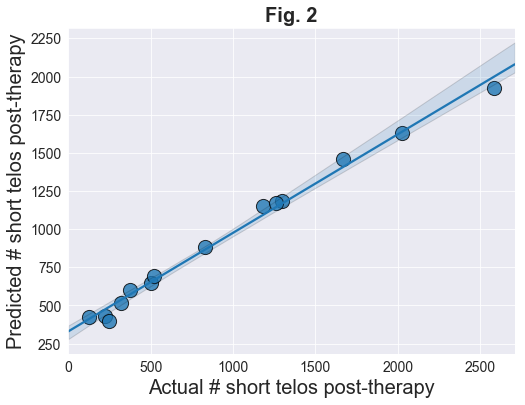

In [116]:
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict)
# ax.set_xlabel('ACTUAL 4C # SHORT TELOS', fontsize=16)
# ax.set_ylabel('PREDICTED 4C # SHORT TELOS BY XGB MODEL', fontsize=16)
# ax.tick_params(labelsize=14)
# plt.savefig('predicting # short telos 3 months post.png')

plt.figure(figsize=(8,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # short telos post-therapy', fontsize=20)
ax.set_ylabel('Predicted # short telos post-therapy', fontsize=20)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig('predicting # short telos 3 months post.png')

# Machine Learning - exploring predictions of chromosome rearrangements

## Loading/merging data for ML

In [396]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [397]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner())])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

## Train/test split 

In [425]:
chr_train, chr_test = train_test_split(cleaned_chr_df, test_size=0.2, shuffle=True, 
                                       stratify=cleaned_chr_df[['patient id', 'timepoint']])

In [399]:
chr_test.shape

(504, 10)

## Initializing cleaning/model pipelines

In [406]:
features = ['# inversions', 
            '# terminal inversions', 
            '# dicentrics', 
            '# translocations'
           ]

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=False, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target='aberration index',
                                                                                 features=features))
                                    ])

In [407]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,
                        )

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                      ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

## Cleaning/modeling data with pipeline

In [408]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

## Bayesian Optimization

In [411]:
target = '4 C aberration index'
features = [col for col in cleaned_chr_train if col != target and col != 'patient id']

X_train = cleaned_chr_train[features].copy()
y_train = cleaned_chr_train[target].copy()

In [412]:
def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
                        subsample, colsample, gamma):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    clf = XGBRegressor(max_depth=max_depth,
                       learning_rate=learning_rate,
                       n_estimators=n_estimators,
                       gamma=gamma, objective='reg:tweedie',)
    
    return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))

pbounds = {
    'learning_rate': (0.1, 0.3),
    'n_estimators': (100, 200),
    'max_depth': (3, 30),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (0.8, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 3),
    }
 
optimizer = BayesianOptimization(
    f=xgboost_hyper_param,
    pbounds=pbounds,
    random_state=1,)

optimizer.maximize(init_points=5, n_iter=3)

|   iter    |  target   | colsample |   gamma   | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.1848   |  0.8834   |  2.161    |  0.1      |  11.16    |  114.7    |  1.0      |
|  2        | -0.1848   |  0.8373   |  1.037    |  0.1794   |  17.55    |  141.9    |  1.0      |
|  3        | -0.1848   |  0.8409   |  2.634    |  0.1055   |  21.1     |  141.7    |  1.0      |
|  4        | -0.1848   |  0.8281   |  0.5943   |  0.2601   |  29.14    |  131.3    |  1.0      |
|  5        | -0.1848   |  0.9753   |  2.684    |  0.117    |  4.054    |  117.0    |  1.0      |
|  6        | -0.1848   |  0.8452   |  2.428    |  0.1496   |  3.437    |  199.9    |  1.0      |


KeyboardInterrupt: 

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [413]:
bo_model = XGBRegressor(n_estimators=100, 
                        max_depth=3, 
                        learning_rate=0.29,
                        objective='reg:squarederror',
                        colsample=.8897,
                        gamma=3.185,
                        random_state=0,
                        )

In [414]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

chr_fit_xgb_model = trp.cv_score_fit_mae_test(train_set=cleaned_chr_train, test_set=cleaned_chr_test,
                                              model=bo_model, cv=5, 
                                              target='4 C aberration index',)

MAE per CV fold: 
[0.11271772 0.17787715 0.24579682 0.20165449 0.18574336] 

MEAN of MAE all folds: 0.1847579063692502
STD of MAE all folds: 0.04301010884903175

MAE of predict_y_test & y_test: 0.33418415841602145
R2 between predict_y_test & y_test: -0.026981615800344194


In [415]:
cleaned_chr_test.head()

,patient id,# inversions,# terminal inversions,# dicentrics,# translocations,4 C aberration index,timepoint_2 irrad @ 4 Gy
0,16,0,0,0,1,1.25,1
3,16,0,0,0,0,1.25,1
4,16,2,0,0,0,1.25,0
5,16,0,0,0,0,1.25,0
6,16,0,1,0,0,1.25,0


In [419]:
target = '4 C aberration index'
features = [col for col in cleaned_chr_test if col != target and col != 'patient id']
features
# predicts = chr_fit_xgb_model.predict(cleaned_chr_test[features])
# combined = pd.concat([cleaned_chr_test.reset_index(), pd.DataFrame({'predictions':predicts})], axis=1)
# predicts

['# inversions',
 '# terminal inversions',
 '# dicentrics',
 '# translocations',
 'timepoint_2 irrad @ 4 Gy']

In [129]:
# testing = chr_fit_xgb_model.predict(chr_train_set[['# inversions', 'timepoint_2 irrad @ 4 Gy']])
# pd.DataFrame(testing)

In [131]:
# q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
#                                                                  model=q_fit_xgb_model, target='4 C # short telos',
#                                                                  clean_process_pipe=q_clean_process_pipe)

In [ ]:
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict)
# ax.set_xlabel('ACTUAL 4C # SHORT TELOS', fontsize=16)
# ax.set_ylabel('PREDICTED 4C # SHORT TELOS BY XGB MODEL', fontsize=16)
# ax.tick_params(labelsize=14)
# plt.savefig('predicting # short telos 3 months post.png')

plt.figure(figsize=(8,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # short telos post-therapy', fontsize=20)
ax.set_ylabel('Predicted # short telos post-therapy', fontsize=20)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig('predicting # short telos 3 months post.png')

12/9/19

CAN SUPPORT VECTOR MACHINE DISTINGUISH MULTIDIMESONIAL CLUSTERED DATA?

HOW TO DISTINGUISH MULTI DIMENSIONAL TIME SERIES DATA?

# Clustering telomere data

In [61]:
train_clean.head()

,individual telomeres,4 C telo means,timepoint_1
0,122.219644,101.402469,1
1,131.103071,93.352253,0
2,106.899427,93.352253,0
3,66.021608,90.680352,1
4,97.916639,106.652869,1


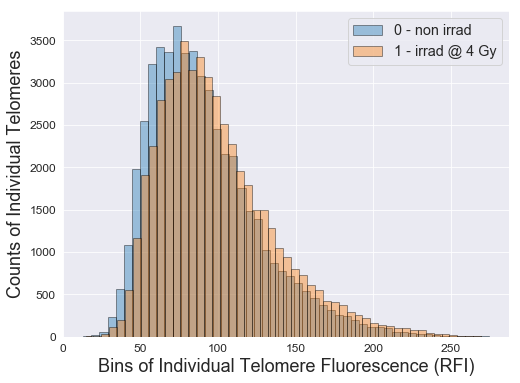

In [81]:
telos_0 = train_clean[train_clean['timepoint_1'] == 0]['individual telomeres']
telos_1 = train_clean[train_clean['timepoint_1'] == 1]['individual telomeres']

plt.figure(figsize=(8,6))
ax = sns.distplot(telos_0, kde=False, label='0 - non irrad')
ax = sns.distplot(telos_1, kde=False, label='1 - irrad @ 4 Gy')
plt.legend(fontsize='x-large')
ax.tick_params(labelsize=12)
ax.set_ylabel('Counts of Individual Telomeres', fontsize=18)
ax.set_xlabel('Bins of Individual Telomere Fluorescence (RFI)', fontsize=18)
plt.savefig('../graphs/nonrad vs irrad telos.png', dpi=400)